# CoinGame solver using multi-agent advantage actor-critic (MAA2C) with a shared classical policy and joint classical critic.

In [8]:
import sys
sys.path.append('../') # Use parent dir.

In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
import eqmarl
import matplotlib.pyplot as plt
import tensorflow.keras as keras
import tensorflow as tf
from pathlib import Path
import numpy as np
import cirq
import functools as ft
from datetime import datetime

In [11]:
# # Disable GPUs.
# tf.config.set_visible_devices([], 'GPU')

# List any available GPUs.
tf.config.list_physical_devices('GPU')

[]

In [12]:
output_dir = Path('./output/')
root_dir = output_dir/'coingame_maa2c_quantum_pomdp_nnreduce_4qubits_central'
root_dir.expanduser().mkdir(parents=True, exist_ok=True)

checkpoint_dir = root_dir / 'checkpoints'

metrics_file = root_dir / 'metrics-{datetime}.json'
model_actor_checkpoint_file = checkpoint_dir / 'actor' / 'cp-{datetime}.ckpt'
model_critic_checkpoint_file = checkpoint_dir / 'critic' / 'cp-{datetime}.ckpt'

In [13]:
n_actions = 4
n_agents = 2
observation_dim = 36

In [14]:
d_qubits = 4
n_layers = 5
keepdims = [0,2,3] # Preserves observations indices [0,2,3], removes index [1] which contains info about other agent locations -- makes observation partially-observable.


# Quantum shared actor.
model_actor = eqmarl.models.generate_model_CoinGame2_actor_quantum_nnreduce_shared_pomdp(
    d_qubits=d_qubits,
    keepdims=keepdims,
    n_layers=n_layers,
    trainable_w_enc=False,
    name=f"actor-quantum-shared",
    )
optimizer_actor = [
    keras.optimizers.Adam(learning_rate=1e-3), #dense kernel
    keras.optimizers.Adam(learning_rate=1e-3), #dense bias
    keras.optimizers.Adam(learning_rate=1e-2), # w_var
    # keras.optimizers.Adam(learning_rate=1e-1), # w_enc
    keras.optimizers.Adam(learning_rate=1e-1), # obs_weights
    ]

model_actor.build((None, observation_dim))
model_actor.summary()


# Quantum joint critic.
model_critic = eqmarl.models.generate_model_CoinGame2_critic_quantum_nnreduce_central_pomdp(
    d_qubits=d_qubits,
    keepdims=keepdims,
    n_agents=n_agents,
    n_layers=n_layers,
    trainable_w_enc=False,
    name=f"critic-quantum-joint",
    )
optimizer_critic = [
    keras.optimizers.Adam(learning_rate=1e-3), #dense kernel
    keras.optimizers.Adam(learning_rate=1e-3), #dense bias
    keras.optimizers.Adam(learning_rate=1e-2), # w_var
    # keras.optimizers.Adam(learning_rate=1e-1), # w_enc
    keras.optimizers.Adam(learning_rate=1e-1), # obs_weights
    ]

model_critic.build((None, n_agents, observation_dim))
model_critic.summary()

Model: "actor-quantum-shared"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input-preprocess (Sequentia  (None, 3, 3, 3)          0         
 l)                                                              
                                                                 
 flatten_1 (Flatten)         (None, 27)                0         
                                                                 
 dense_1 (Dense)             (None, 12)                336       
                                                                 
 reshape_6 (Reshape)         (None, 4, 3)              0         
                                                                 
 HybridVariationalEncodingPQ  (None, 4)                132       
 C (HybridVariationalEncodin                                     
 gPQC)                                                           
                                              

In [15]:
model_actor.trainable_variables

[<tf.Variable 'dense_1/kernel:0' shape=(27, 12) dtype=float32, numpy=
 array([[ 0.3437219 ,  0.15036699,  0.01170281,  0.22788098,  0.10008007,
         -0.21145782,  0.12594923,  0.13535896, -0.30484012,  0.30682263,
          0.16639712,  0.18803927],
        [-0.21152665,  0.29252663, -0.16388987, -0.24448943, -0.23505653,
          0.06411037,  0.31748387, -0.2545851 ,  0.36077753, -0.01209444,
          0.07083544, -0.3498867 ],
        [ 0.16737661, -0.01696512,  0.13610688,  0.17243192,  0.05378139,
         -0.27944112, -0.35517126, -0.05250201, -0.33219674,  0.34142628,
         -0.10247818, -0.03745455],
        [-0.05013299,  0.21930423,  0.14257273,  0.31971356, -0.25071588,
         -0.2643339 , -0.05781621, -0.3451709 , -0.01930851,  0.16477183,
         -0.02190048, -0.14264156],
        [ 0.10442412,  0.25306752, -0.19398025,  0.1368728 , -0.01062945,
         -0.03157559, -0.01611862,  0.24915615,  0.08128962,  0.05865431,
          0.30593535, -0.32701328],
        [ 

In [16]:
model_critic.trainable_variables

[<tf.Variable 'locally_connected1d_1/kernel:0' shape=(2, 27, 12) dtype=float32, numpy=
 array([[[-1.93369091e-01,  5.36720157e-02,  3.96300852e-02,
          -2.67257959e-01,  4.85126376e-02,  4.81614470e-02,
           1.45911485e-01,  1.19464874e-01,  2.43608266e-01,
           3.62256169e-02,  2.43349582e-01, -1.11531287e-01],
         [-1.31348968e-02, -5.70315123e-02, -1.12629175e-01,
          -1.45357549e-02, -5.67372590e-02,  2.22536147e-01,
          -9.43089277e-02,  8.37435424e-02,  2.15429336e-01,
           2.18777061e-01,  3.64905298e-02, -2.27639124e-01],
         [-7.95699060e-02,  6.01533055e-02, -4.33916301e-02,
           4.38888967e-02, -2.61378616e-01, -1.12628251e-01,
          -1.80472523e-01,  1.12491101e-01,  1.29061639e-02,
          -8.39128196e-02,  5.66511750e-02,  1.58912003e-01],
         [-2.07650006e-01, -9.57234800e-02, -1.46298975e-01,
          -2.25282744e-01,  2.28295952e-01, -1.44847989e-01,
           3.35056782e-02, -1.51523679e-01,  1.74702346e

## Training

In [17]:
gamma = 0.99
alpha = 0.001
params = {
    'domain_name': 'CoinGame-2',
    'gamma': gamma,
    'time_limit': 50,
}
env = eqmarl.environments.coin_game.vector_coin_game_make(params)

def episode_metrics_callback(env: eqmarl.environments.coin_game.CoinGameEnvironment):
    
    coins_collected = env.domain_values()[env.get_index('coins_collected')]
    own_coins_collected = env.domain_values()[env.get_index('own_coins_collected')]
    undiscounted_reward = np.sum(env.undiscounted_returns)
    discounted_reward = np.sum(env.discounted_returns)
    own_coin_rate = own_coins_collected/coins_collected if coins_collected != 0 else 0
    
    return dict(
        coins_collected=coins_collected,
        own_coins_collected=own_coins_collected,
        own_coin_rate=own_coin_rate,
        undiscounted_reward=undiscounted_reward,
        discounted_reward=discounted_reward,
    )

algo = eqmarl.algorithms.MAA2C(
    env=env,
    model_actor=model_actor,
    model_critic=model_critic,
    optimizer_actor=optimizer_actor,
    optimizer_critic=optimizer_critic,
    gamma=gamma,
    alpha=alpha,
    episode_metrics_callback=episode_metrics_callback,
    )

In [18]:
# Time of training start.
datetime_start = datetime.now().isoformat()

# Set model checkpoint files to have timestamp of training start.
model_actor_checkpoint_file_current = str(model_actor_checkpoint_file).format(datetime=datetime_start)
model_critic_checkpoint_file_current = str(model_critic_checkpoint_file).format(datetime=datetime_start)
metrics_file_current = str(metrics_file).format(datetime=datetime_start)

# Train models using algorithm.
reward_history, metrics_history = algo.train(
    n_episodes=3000,
    callbacks=[
        eqmarl.AlgorithmResultCheckpoint(filepath=metrics_file_current, save_freq=100, verbose=True),
        # eqmarl.TensorflowModelCheckpoint(model=model_actor, filepath=model_actor_checkpoint_file_current, save_freq=100, verbose=True),
        ],
    )

# Save results to file.
algo.save_train_results(metrics_file_current, reward_history, metrics_history)

Training for 3000 episodes, press 'Ctrl+C' to terminate early
Episode 0:   0%|          | 0/3000 [00:00<?, ?episode/s]

Episode 3000: 100%|██████████| 3000/3000 [2:16:53<00:00,  2.74s/episode, coins_collected=25, discounted_reward=19.5, episode_reward=[12. 13.], own_coin_rate=1, own_coins_collected=25, undiscounted_reward=25]


In [19]:
# Save models to file.
datetimestring = datetime.now().isoformat()
model_actor.save_weights(str(model_actor_checkpoint_file).format(datetime=datetimestring))
model_critic.save_weights(str(model_critic_checkpoint_file).format(datetime=datetimestring))

In [20]:
model_actor.trainable_variables

[<tf.Variable 'dense_1/kernel:0' shape=(27, 12) dtype=float32, numpy=
 array([[ 0.4202859 ,  0.37001288, -0.08487023, -0.14345916,  0.13159427,
          0.19783786,  0.20989792,  0.2938166 , -0.3748115 ,  0.23265503,
          0.18488578,  0.13900654],
        [-0.01823901,  0.7107894 , -0.39432687, -0.3225076 , -0.1630746 ,
         -0.06062933,  0.15132566, -0.27025852,  0.45153713, -0.01313039,
          0.0873768 , -0.33382273],
        [-0.00603419, -0.05110758,  0.4174718 ,  0.36639926,  0.20337582,
         -0.39774394, -0.4770737 , -0.10991278, -0.3482681 ,  0.67920643,
         -0.24293765,  0.00581627],
        [-0.06717902,  0.15558982, -0.12190554,  0.2428693 , -0.00454147,
         -0.09741861,  0.00128456, -0.201538  , -0.1350707 ,  0.08697459,
          0.0949996 , -0.1591821 ],
        [ 0.12822914,  0.1954201 , -0.08073175,  0.07032742, -0.08257335,
         -0.23979741, -0.10032877,  0.24620767,  0.22327763,  0.30952373,
          0.4035861 , -0.4619959 ],
        [ 

In [21]:
model_critic.trainable_variables

[<tf.Variable 'locally_connected1d_1/kernel:0' shape=(2, 27, 12) dtype=float32, numpy=
 array([[[-8.17459822e-02,  3.54731046e-02, -6.37233779e-02,
          -1.63325947e-02,  1.13954410e-01, -1.58185124e-01,
          -8.97291303e-03,  2.42791530e-02,  8.00486654e-02,
           7.62147009e-02,  1.94969580e-01, -1.60080373e-01],
         [-8.31226185e-02, -1.44974366e-01,  3.09649222e-02,
           1.43755868e-01,  9.20068100e-02,  2.00544938e-01,
           1.27809227e-01,  1.11902252e-01,  1.83307171e-01,
           1.39994115e-01,  1.15242690e-01,  2.12888443e-03],
         [-1.57303885e-02, -1.87748611e-01, -2.31534004e-01,
          -9.44196209e-02, -3.06060255e-01, -2.18023449e-01,
          -4.69731726e-02,  6.59862980e-02,  4.88177575e-02,
           5.12054823e-02,  3.05344928e-02,  9.84257609e-02],
         [-1.87557623e-01,  7.04356730e-02,  1.01252347e-01,
          -1.06822878e-01,  1.64261803e-01, -3.57540883e-02,
          -1.78256512e-01,  2.80984212e-03, -2.89135072e

In [22]:
# Load metrics from file.
reward_history, metrics_history = algo.load_train_results(metrics_file_current)

Text(0.5, 1.0, 'Score')

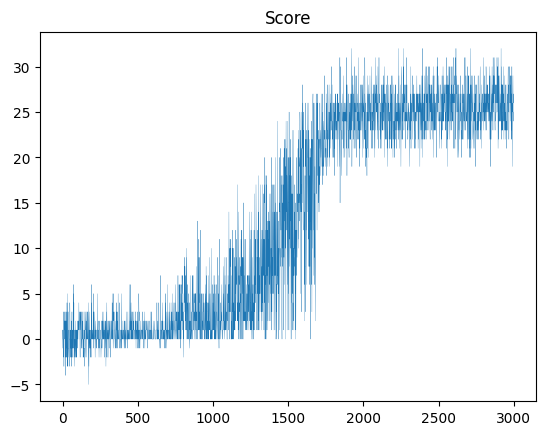

In [23]:
score = np.sum(reward_history, axis=-1)
plt.plot(score, linewidth=.2)
plt.title('Score')

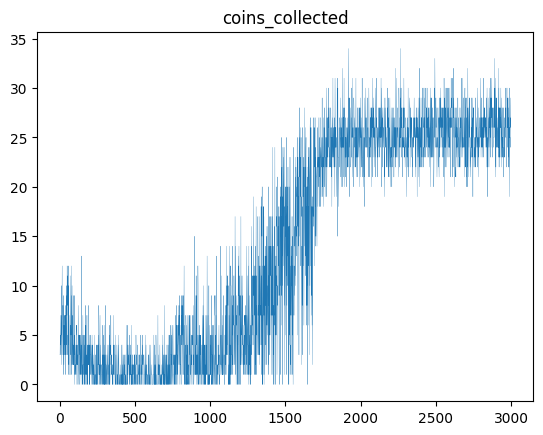

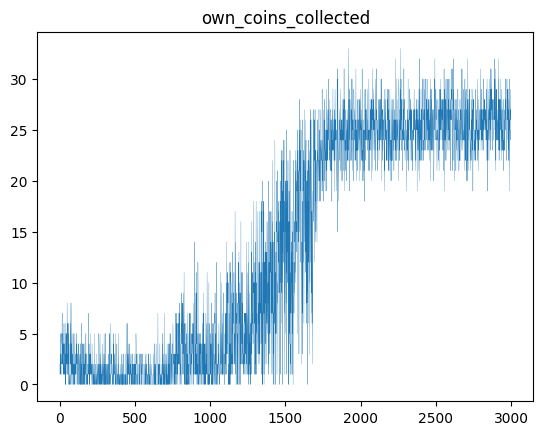

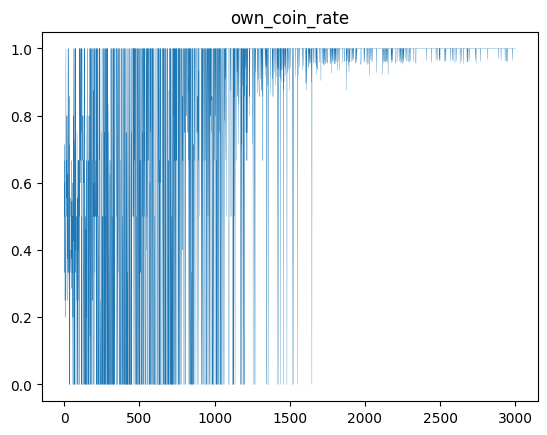

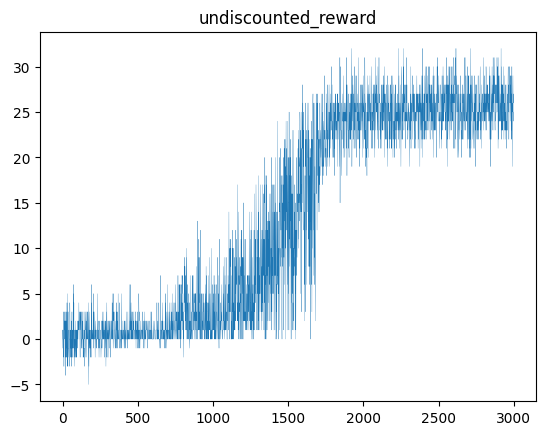

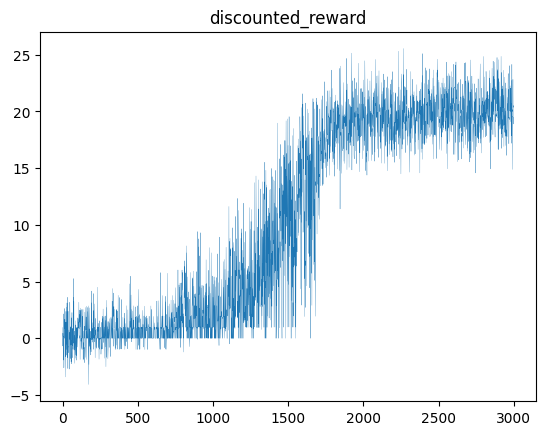

In [24]:
for k, v in metrics_history.items():
    plt.figure()
    plt.title(k)
    plt.plot(v, linewidth=.2)